In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from statsmodels.tsa import api
from statsmodels.tsa import ar_model
from statsmodels.tsa import seasonal
import statsmodels.api as sm
from sklearn import metrics

%matplotlib inline

In [3]:
df = pd.read_csv('data/tovar_moving.csv', index_col=['date'], parse_dates=['date'])
df

,qty
date,
2009-12-25,72314.0
2009-12-26,66586.0
2009-12-27,125199.0
2009-12-28,91544.0
2009-12-29,76995.0
...,...
2013-11-28,320717.0
2013-11-29,444416.0
2013-11-30,323577.0


<AxesSubplot:xlabel='date'>

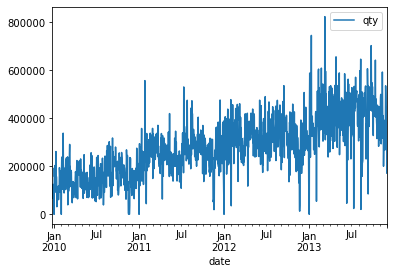

In [5]:
df.plot()

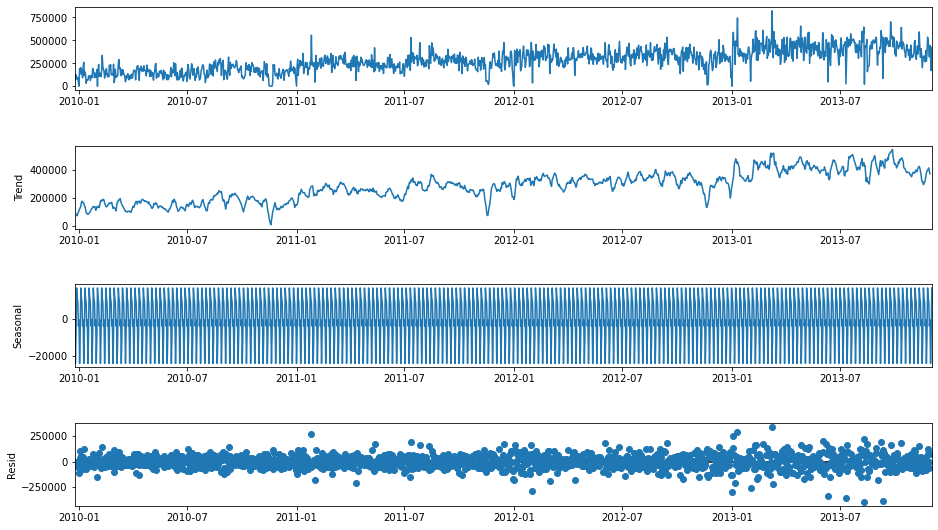

In [7]:
decomp = seasonal.seasonal_decompose(df)
fig = decomp.plot()
fig.set_size_inches((15, 8))
plt.show()

In [9]:
train_data = df.iloc[:-1]
test_data = df.iloc[-1]

In [12]:
ses = api.SimpleExpSmoothing(train_data)
alpha = 0.7
model = ses.fit(smoothing_level=alpha, optimized=False)
exp_pred = model.forecast(1)
print('pred', exp_pred)
print('test', test_data)

pred 2013-12-02    225015.522647
Freq: D, dtype: float64
test qty    423846.0
Name: 2013-12-02 00:00:00, dtype: float64


/home/vadim/anaconda3/envs/sf/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [13]:
def stat_test(df):
    test = sm.tsa.adfuller(df)
    print('adf: ', test[0])
    print('pvalue: ', test[1])
    print('Critical values: ', test[4])
    if test[0] > test[4]['5%']:
        print('Есть единичные корни, ряд не стационарен')
    else:
        print('Единичных корней нет, ряд стационарен')
        
stat_test(train_data)

adf:  -2.2553026410337966
pvalue:  0.18678903123416574
Critical values:  {'1%': -3.434973278556316, '5%': -2.8635818545830376, '10%': -2.567857072940785}
Есть единичные корни, ряд не стационарен


In [14]:
dfdiff1 = df.diff(periods=1).dropna()
stat_test(dfdiff1)

adf:  -13.82183986522664
pvalue:  7.878856681050369e-26
Critical values:  {'1%': -3.4349700122033804, '5%': -2.8635804131233096, '10%': -2.567856305330816}
Единичных корней нет, ряд стационарен


/home/vadim/anaconda3/envs/sf/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


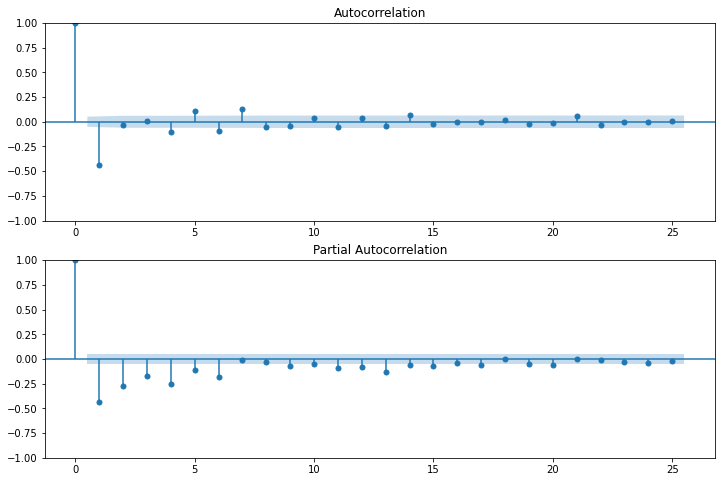

In [15]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dfdiff1.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dfdiff1, lags=25, ax=ax2)

In [16]:
p = 6

In [17]:
armodel = ar_model.AutoReg(train_data, lags=p).fit()
print(armodel.summary())

ar_pred = armodel.predict(start=len(train_data), end=len(train_data))
ar_pred


                            AutoReg Model Results                             
Dep. Variable:                    qty   No. Observations:                 1438
Model:                     AutoReg(6)   Log Likelihood              -18221.056
Method:               Conditional MLE   S.D. of innovations          81248.064
Date:                Sun, 02 Oct 2022   AIC                          36458.111
Time:                        14:41:03   BIC                          36500.246
Sample:                    12-31-2009   HQIC                         36473.844
                         - 12-01-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.047e+04   6160.175      4.946      0.000    1.84e+04    4.25e+04
qty.L1         0.3074      0.026     11.654      0.000       0.256       0.359
qty.L2         0.1582      0.027      5.835      0.0

/home/vadim/anaconda3/envs/sf/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/vadim/anaconda3/envs/sf/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and NumericIndex with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


2013-12-02    318174.284553
Freq: D, dtype: float64

In [19]:
print('ses: ', metrics.mean_squared_error(test_data, exp_pred))
print('ar: ', metrics.mean_squared_error(test_data, ar_pred))
print(metrics.mean_squared_error(test_data, exp_pred) - metrics.mean_squared_error(test_data, ar_pred))

ses:  39533558724.37031
ar:  11166511445.472889
28367047278.89742
